<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/movie-recommendations/MovieRecommendationsUsingTwoTowerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scann

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dot, Flatten, IntegerLookup, Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
from keras import regularizers
import tensorflow_datasets as tfds
from keras import initializers
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import io
import scann

# Download the MovieLens full dataset

In [2]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

path_to_downloaded_file = tf.keras.utils.get_file("ml-latest.zip", url, extract=True)
print(path_to_downloaded_file)
dataset_dir = os.path.join(os.path.dirname(path_to_downloaded_file), 'ml-latest')
print(dataset_dir)
ratings_dir = os.path.join(dataset_dir, "ratings.csv")
movies_dir = os.path.join(dataset_dir, "movies.csv")

350896731/350896731 [==============================] - 3s 0us/step
/root/.keras/datasets/ml-latest.zip
/root/.keras/datasets/ml-latest


# Transform the movie dataset
Examine the movies dataset. It seems the movie ids are not continuous numbers, but sparse integers. We will map them to new ids using integer_lookup into a new set of ids to use in the embedding matrix.

In [3]:
import pandas as pd
df_movies = pd.read_csv(movies_dir)
integer_lookup = IntegerLookup(name="movieId Lookup")
integer_lookup.adapt(df_movies["movieId"])
df_movies["movieIdDense"] = integer_lookup(df_movies["movieId"])
df_movies

,movieId,title,genres,movieIdDense
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,86537
1,2,Jumanji (1995),Adventure|Children|Fantasy,86536
2,3,Grumpier Old Men (1995),Comedy|Romance,86535
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,86534
4,5,Father of the Bride Part II (1995),Comedy,86533
...,...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),Action|Drama,5
86533,288971,Ouija Japan (2021),Action|Horror,4
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,3
86535,288977,Skinford: Death Sentence (2023),Crime|Thriller,2


# Transform the ratings dataset
We will add the same dense movie id that we created earlier to this so that we can use these during training.

In [4]:
df_ratings = pd.read_csv(ratings_dir)
df_ratings["movieIdDense"] = integer_lookup(df_ratings["movieId"])
df_ratings

,userId,movieId,rating,timestamp,movieIdDense
0,1,1,4.0,1225734739,86537
1,1,110,4.0,1225865086,86429
2,1,158,4.0,1225733503,86381
3,1,260,4.5,1225735204,86280
4,1,356,5.0,1225735119,86186
...,...,...,...,...,...
33832157,330975,8340,2.0,1091583256,78804
33832158,330975,8493,2.5,1091585709,78714
33832159,330975,8622,4.0,1091581777,78626
33832160,330975,8665,3.0,1091581765,78583


In [5]:
NUM_RATINGS = df_ratings["userId"].size
NUM_USERS=df_ratings["userId"].nunique()
NUM_MIN_USER_ID = df_ratings["userId"].min()
NUM_MAX_USER_ID = df_ratings["userId"].max()

NUM_MOVIES = df_movies["movieId"].nunique()
NUM_MIN_MOVIE_ID = df_movies["movieId"].min()
NUM_MAX_MOVIE_ID = df_movies["movieId"].max()
ALL_MOVIE_IDS = df_movies['movieIdDense'].unique()

# Build and train the model

In [6]:
train, test = train_test_split(df_ratings, test_size=0.2)
ROW_COUNT = train.shape[0]
train.head()

,userId,movieId,rating,timestamp,movieIdDense
7372468,72081,81834,3.0,1492459383,70996
4561184,44538,2888,3.0,1447036812,83741
27474192,268085,3979,3.5,1272024159,82661
455616,4389,1131,3.5,1056444689,85434
20434911,199488,648,3.5,1076295573,85900


In [7]:
def build_model(num_users, num_movies, embedding_dim):
  movie_input = Input(shape=(1,), name="movie_id")
  movie_emb = Embedding(input_dim=num_movies+1, output_dim=embedding_dim,
                        name='movie_emb')(movie_input)
  movie_vec = Flatten(name='flatten_movie')(movie_emb)
  movie_model = Model(inputs=movie_input, outputs=movie_vec)


  user_input = Input(shape=(1,), name="user_id")
  user_emb = Embedding(input_dim=num_users+1, output_dim=embedding_dim,
                      name='user_emb')(user_input)
  user_vec = Flatten(name='flatten_user')(user_emb)
  user_model = Model(inputs=user_input, outputs=user_vec)

  x = Dot(name = 'dot_product', normalize=True, axes=2)([movie_emb, user_emb])
  x = Dense(10, activation='relu')(x)
  result = Dense(1, activation=None)(x)
  model = Model([movie_input, user_input], result)
  return model, movie_model, user_model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 movie_emb (Embedding)       (None, 1, 20)                1730760   ['movie_id[0][0]']            
                                                                                                  
 user_emb (Embedding)        (None, 1, 20)                6619520   ['user_id[0][0]']             
                                                                                            

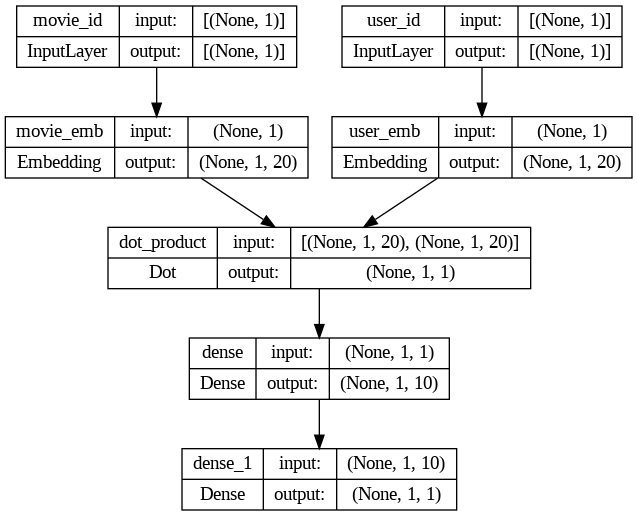

In [8]:
# Embedding dimension should be around the 4th root of vacab (~86000 movies)
EMBEDDING_DIM = 20
model, movie_model, user_model = build_model(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='mean_absolute_error')
model.summary()
plot_model(model, show_shapes=True)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=5)]

history = model.fit([train.movieIdDense, train.userId],train.rating, batch_size=100000,
                              epochs=50, validation_data = ([test.movieIdDense, test.userId],test.rating),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/50
271/271 [==============================] - 36s 127ms/step - loss: 3.1049 - val_loss: 1.7843
Epoch 2/50
271/271 [==============================] - 32s 118ms/step - loss: 0.8706 - val_loss: 0.6582
Epoch 3/50
271/271 [==============================] - 32s 117ms/step - loss: 0.6284 - val_loss: 0.6274
Epoch 4/50
271/271 [==============================] - 32s 119ms/step - loss: 0.5912 - val_loss: 0.6152
Epoch 5/50
271/271 [==============================] - 32s 119ms/step - loss: 0.5677 - val_loss: 0.6098
Epoch 6/50
271/271 [==============================] - 38s 139ms/step - loss: 0.5520 - val_loss: 0.6072
Epoch 7/50
271/271 [==============================] - 35s 128ms/step - loss: 0.5408 - val_loss: 0.6059
Epoch 8/50
271/271 [==============================] - 35s 128ms/step - loss: 0.5323 - val_loss: 0.6052
Epoch 9/50
271/271 [==============================] - 35s 127ms/step - loss: 0.5254 - val_loss: 0.6047
Epoch 10/50
271/271 [==============================] - 35s 129ms/step - l

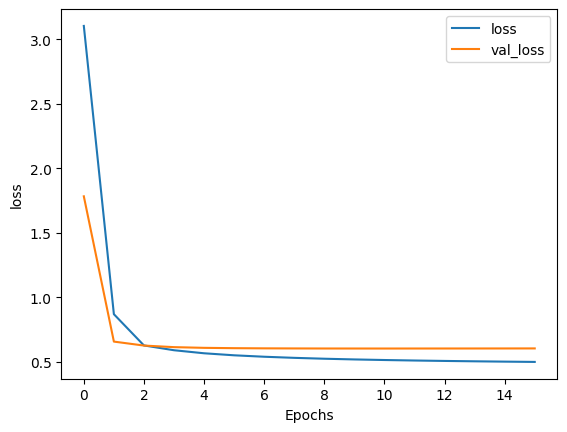

In [10]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()


plot_graphs(history, "loss")

# Movie Similarties
Our model has learnt tbe embeddings for users and movies in the same embedding space. We can now use these embeddings to find movies similar to other movies

In [11]:
movie_embeddings = movie_model.predict(np.array(ALL_MOVIE_IDS))
k = int(np.sqrt(movie_embeddings.shape[0]))
searcher = scann.scann_ops_pybind.builder(movie_embeddings, 10, "dot_product").tree(
    num_leaves=k, num_leaves_to_search=int(k/20), training_sample_size=k).score_brute_force(2).reorder(7).build()

def get_related_movies(id, movie_embeddings):
  query_vector = movie_embeddings[id]
  results = searcher.search(query_vector)
  return results[0]

def get_related_movies_df(movie_list):
  movies = []
  for movie_row_id in movie_list:
    related_movies = []
    related_movies.append(df_movies["title"][movie_row_id])
    related_movie_ids = get_related_movies(movie_row_id, movie_embeddings)
    for related_movie_id in related_movie_ids:
      related_movies.append(df_movies["title"][related_movie_id])
    movies.append(related_movies)
  df = pd.DataFrame(movies).transpose()
  return df

2705/2705 [==============================] - 4s 1ms/step


In [12]:
# Toy Story (1995), Live and Let Die (1973), For a Few Dollars More, Tora! Tora! Tora! (1970), Memento (2000)
# Generate movies similar to the above four movies.
movie_list = [0, 2899, 3581, 3882, 4123]
df = get_related_movies_df(movie_list)
df

,0,1,2,3,4
0,Toy Story (1995),Live and Let Die (1973),For a Few Dollars More (Per qualche dollaro in...,"Eagle Has Landed, The (1976)",Memento (2000)
1,Toy Story 2 (1999),For Your Eyes Only (1981),Once Upon a Time in the West (C'era una volta ...,"Eagle Has Landed, The (1976)",Memento (2000)
2,Toy Story (1995),Diamonds Are Forever (1971),For a Few Dollars More (Per qualche dollaro in...,Hamburger Hill (1987),Confessions of a Dangerous Mind (2002)
3,Toy Story 3 (2010),You Only Live Twice (1967),"Bridge Too Far, A (1977)",Patriot Games (1992),The Machinist (2004)
4,Up (2009),Licence to Kill (1989),Rope (1948),"Enforcer, The (1976)",Jarhead (2005)
5,Finding Nemo (2003),Thunderball (1965),"Fistful of Dollars, A (Per un pugno di dollari...",Tora! Tora! Tora! (1970),Burn After Reading (2008)
6,"Incredibles, The (2004)",Octopussy (1983),"Good, the Bad and the Ugly, The (Buono, il bru...","Dead Pool, The (1988)","Three Billboards Outside Ebbing, Missouri (2017)"
7,Ratatouille (2007),Moonraker (1979),"Party, The (1968)",Sniper (1993),One Hour Photo (2002)
8,"Monsters, Inc. (2001)","Man with the Golden Gun, The (1974)",Strangers on a Train (1951),"Bridge Too Far, A (1977)",Munich (2005)
9,"Bug's Life, A (1998)",Never Say Never Again (1983),"Play It Again, Sam (1972)",Force 10 from Navarone (1978),"Das Experiment (Experiment, The) (2001)"


# Movie recommendations for a user
We can now get the embeddings for a user and recommend movies close to the user in the embeding space.

In [13]:
# Print a user embedding
def recommend_movies(user_id):
  user_vector = user_model.predict([np.array([user_id])])[0]
  results = searcher.search(user_vector)
  for related_movie_id in results[0]:
    print(df_movies["title"][related_movie_id])
recommend_movies(610)

1/1 [==============================] - 0s 33ms/step
Natural Born Pranksters (2016)
The Ark (2007)
Murder Manual (2020)
The Resort (2021)
Marshal of Finland, The (Suomen Marsalkka) (2012)
American Soldiers (2005)
Range 15 (2016)
The Second Wind (2007)
In omaggio all'arte italiana! (2015)
Megalodon (2004)


# Generate vector and metadata files for embedding visualization of the movies

In [14]:
# Generate files for embedding visualization
movie_embeddings = movie_model.predict(np.array(ALL_MOVIE_IDS))
embedding_columns = ['e'+str(i) for i in range(EMBEDDING_DIM)]
df_movie_embedding = pd.DataFrame(
    movie_embeddings,
    columns=embedding_columns)
result = pd.concat([df_movies, df_movie_embedding], axis=1)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for index, row in result.iterrows():
  row_embeddings = [str(row[col_name]) for col_name in embedding_columns]
  out_m.write(row['title'] + "\n")
  out_v.write('\t'.join(row_embeddings) + '\n')

out_v.close()
out_m.close()

2705/2705 [==============================] - 3s 1ms/step



#Use the vectors downloaded to look at the embeddings of movies and their nearest neighbors


![picture](https://drive.usercontent.google.com/download?id=1XmMtBVsgGqJ77VOmJM5NuIF_AfF_7F72)



